In [141]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.colors import Normalize
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import pathlib as pl

plt.style.use('style.mplstyle')

%config InlineBackend.figure_format = 'retina'

here = pl.Path.cwd()
fig_pth = here / 'Figures'

# Signature genes

In [142]:
def symmetrize(x):
    return np.hstack([x, x[:, ::-1]])[:,::2]

def circularize(x):
    return np.hstack([x, x[:, 0].reshape(-1, 1)])

## Define population and draw samples

In [143]:
SEED = 1
n_genes = 5
n_patients = 5
r_max = 6

h_color = 'C0'
d_color = 'C1'

# Averages for lognormal distribution
locs = np.arange(n_genes)
locs = np.vstack([locs, locs+stats.norm(-1, 1).rvs(n_genes, random_state=SEED)])

# Generate a range of population averages for each gene
pop_avgs = stats.lognorm(loc=locs, s=1.2).rvs([2, n_genes], random_state=SEED)

# Inversely sort each condition
pop_avgs = np.sort(pop_avgs, axis=1)
pop_avgs[1, :] = pop_avgs[1, ::-1]

# Symmetrize and circularize to define the final population averages
pop_avgs = circularize(symmetrize(pop_avgs))

# Rescale averages values to [0, 5]
pop_avgs = pop_avgs / pop_avgs.max() * (r_max-1)

labels = np.arange(n_genes)+1
labels = [*labels, labels[0]]
label_loc = np.linspace(start=0, stop=2 * np.pi, num=n_genes+1)

# Draw samples from each population average and circularize
scales = stats.uniform(0.2, 0.5).rvs([1, n_genes], random_state=SEED)

samples = stats.lognorm(loc=pop_avgs[:, :-1]-1, s=scales).rvs([n_patients, 2, n_genes], random_state=SEED)
samples = np.moveaxis(samples, 0, -1)
samples = np.concatenate([samples, samples[:, [0], :]], axis=1)

### Plotting functions

In [144]:
def find_centroid(rs):
    rs = np.expand_dims(rs, axis=-1) if len(rs.shape) == 2 else rs
    θs = np.expand_dims(label_loc, axis=(0,2))
    
    # Convert from polar to cartesian coordinates
    xy = np.stack([np.cos(θs)*rs, np.sin(θs)*rs], axis=-1)
    x = np.cos(θs)*rs
    y = np.sin(θs)*rs
    
    # Centroid of a polygon
    A = 1/2 * np.sum(np.cross(xy[:, :-1], xy[:, 1:]), axis=1, keepdims=True)
    Cx = 1/(6*A) * np.sum((xy[:, :-1, :, 0] + xy[:, 1:, :, 0]) * np.cross(xy[:, :-1, ...], xy[:, 1:, ...]), axis=1, keepdims=True)
    Cy = 1/(6*A) * np.sum((xy[:, :-1, :, 1] + xy[:, 1:, :, 1]) * np.cross(xy[:, :-1, ...], xy[:, 1:, ...]), axis=1, keepdims=True)
    
    centroid_r = np.sqrt(Cx**2 + Cy**2)
    centroid_θ = np.arctan2(Cy, Cx) % (2*np.pi)
    
    return centroid_θ, centroid_r

In [145]:
def prepare_radar_plot(figsize=None):
    figsize = figsize or (8, 8)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(polar=True)

    _ = ax.set_thetagrids(np.degrees(label_loc), labels=labels)
    ax.set_yticklabels([])
    ax.set_ylim(0, r_max)
    ax.set_theta_zero_location("N")
    
    return fig, ax

def rotate_radar_labels(ax):
    angles = np.linspace(0,2*np.pi,len(ax.get_xticklabels())) % (2*np.pi)
    angles = np.rad2deg(angles)
    labels = []
    for label, angle in zip(ax.get_xticklabels(), angles):
        x,y = label.get_position()
        lab = ax.text(x,y, 'RNA '+label.get_text(),
                      fontsize=16,
                      transform=label.get_transform(),
                      ha=label.get_ha(), va=label.get_va())
        lab.set_rotation(angle)
        labels.append(lab)
    ax.set_xticklabels([])

## Empty radar

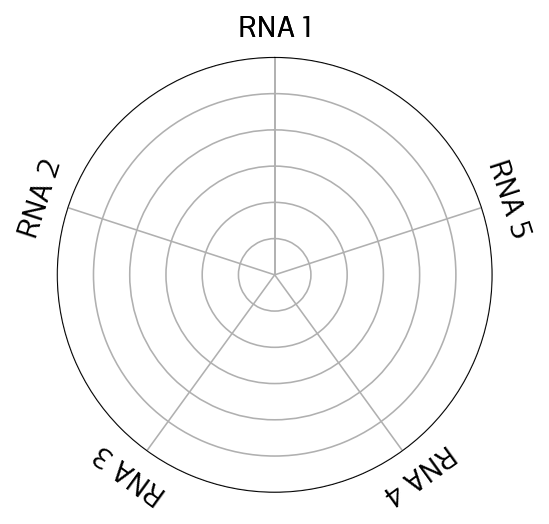

In [146]:
fig, ax = prepare_radar_plot(figsize=(4,4))
rotate_radar_labels(ax)
fig.savefig(fig_pth / 'blank_radar.svg', bbox_inches='tight')
fig.savefig(fig_pth / 'blank_radar.png', dpi=300, bbox_inches='tight')

## Disease patients

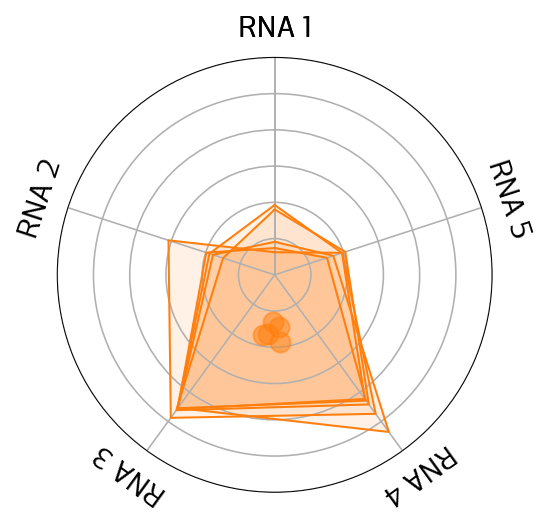

In [147]:
fig, ax = prepare_radar_plot(figsize=(4,4))

# Individual samples
ax.plot(label_loc, samples[0, ...], 
        color=d_color, lw=1, 
        # marker='o', ms=5
        )
for sample in samples[0, ...].T:
    ax.fill(label_loc, sample, color=d_color, alpha=0.1)

# Individual sample centroids
centroid_θ, centroid_r = find_centroid(samples)
ax.plot(centroid_θ[0, :], centroid_r[0, :], 'o', ms=10, color=d_color, alpha=0.5)

rotate_radar_labels(ax)
fig.savefig(fig_pth / 'Individual_samples_disease.svg', bbox_inches='tight')
fig.savefig(fig_pth / 'Individual_samples_disease.png', dpi=300, bbox_inches='tight')


## Healthy patients

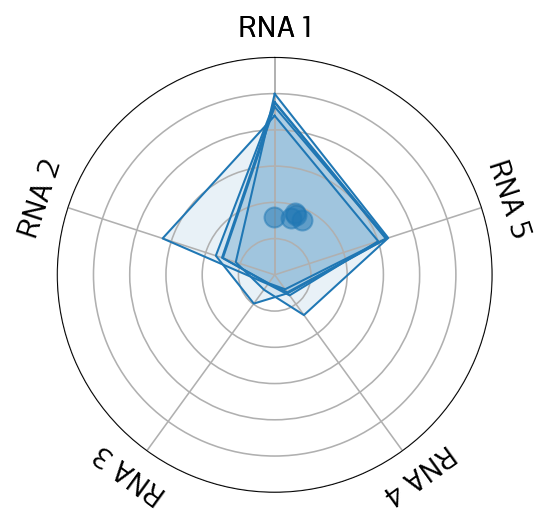

In [148]:
fig, ax = prepare_radar_plot(figsize=(4,4))

# Individual samples
ax.plot(label_loc, samples[1, ...], 
        color=h_color, lw=1, 
        # marker='o', ms=5
        )
for sample in samples[1, ...].T:
    ax.fill(label_loc, sample, color=h_color, alpha=0.1)

# Individual sample centroids
centroid_θ, centroid_r = find_centroid(samples)
ax.plot(centroid_θ[1, :], centroid_r[1, :], 'o', ms=10, color=h_color, alpha=0.5)

rotate_radar_labels(ax)
fig.savefig(fig_pth / 'Individual_samples_healthy.svg', bbox_inches='tight')
fig.savefig(fig_pth / 'Individual_samples_healthy.png', dpi=300, bbox_inches='tight')

## Population plots

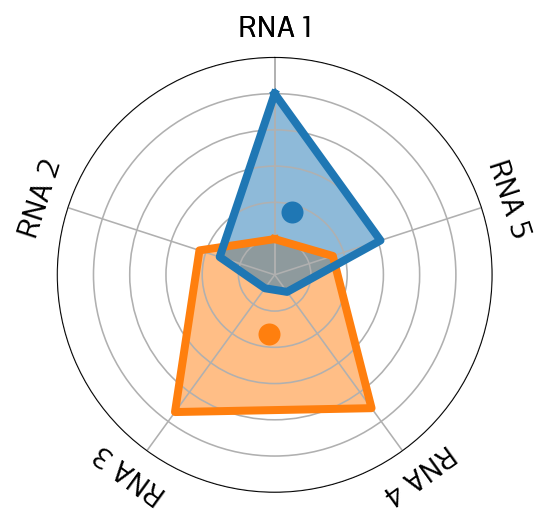

In [149]:
fig, ax = prepare_radar_plot(figsize=(4,4))

ax.plot(label_loc, pop_avgs[0, :], color=d_color, lw=4)
# ax.plot(label_loc, samples[0, :, :5], color=h_color, lw=1, alpha=0.5)
ax.fill(label_loc, pop_avgs[0, :], color=d_color, alpha=0.5)

ax.plot(label_loc, pop_avgs[1, :], color=h_color, lw=4)
# ax.plot(label_loc, samples[1, :, :5], color=d_color, lw=1, alpha=0.5)
ax.fill(label_loc, pop_avgs[1, :], color=h_color, alpha=0.5)

# Find population centroids
centroid_θ, centroid_r = find_centroid(pop_avgs)
ax.plot(centroid_θ[0], centroid_r[0], 'o', color=d_color, ms=10)
ax.plot(centroid_θ[1], centroid_r[1], 'o', color=h_color, ms=10)

rotate_radar_labels(ax)
fig.savefig(fig_pth / 'Population_averages.svg', bbox_inches='tight')
fig.savefig(fig_pth / 'Population_averages.png', dpi=300, bbox_inches='tight')

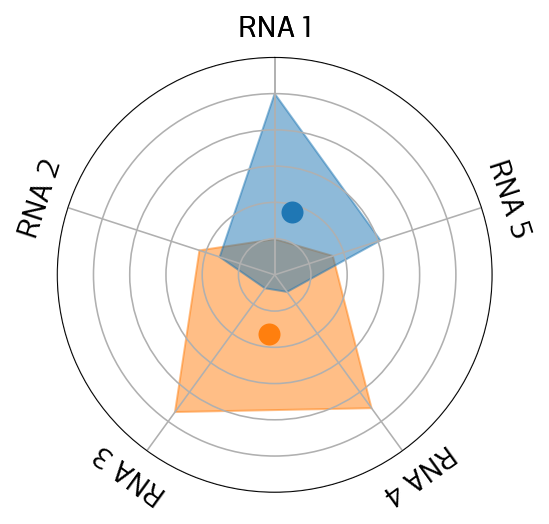

In [150]:
fig, ax = prepare_radar_plot(figsize=(4,4))

# ax.plot(label_loc, pop_avgs[0, :], color=h_color, lw=4)
# ax.plot(label_loc, samples[0, :, :5], color=h_color, lw=1, alpha=0.5)
ax.fill(label_loc, pop_avgs[0, :], color=d_color, alpha=0.5)

# ax.plot(label_loc, pop_avgs[1, :], color=d_color, lw=4)
# ax.plot(label_loc, samples[1, :, :5], color=d_color, lw=1, alpha=0.5)
ax.fill(label_loc, pop_avgs[1, :], color=h_color, alpha=0.5)

# # Find population centroids
centroid_θ, centroid_r = find_centroid(pop_avgs)
ax.plot(centroid_θ[0], centroid_r[0], 'o', color=d_color, ms=10)
ax.plot(centroid_θ[1], centroid_r[1], 'o', color=h_color, ms=10)

rotate_radar_labels(ax)
fig.savefig(fig_pth / 'Population_averages_filled.svg', bbox_inches='tight')
fig.savefig(fig_pth / 'Population_averages_filled.png', dpi=300, bbox_inches='tight')

# Extra genes

## Filled Radar

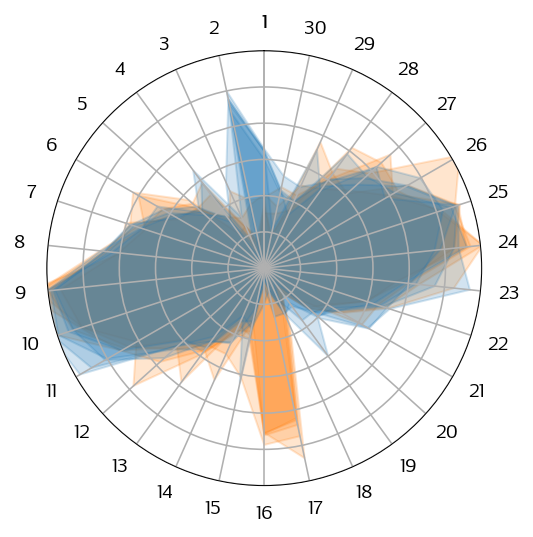

In [151]:
n_extra_genes = 30 - n_genes
extra_locs = np.sort(stats.uniform(0, r_max-1).rvs(n_extra_genes, random_state=SEED))

extra_avgs = stats.lognorm(loc=extra_locs, s=0.2).rvs([2, n_extra_genes], random_state=SEED)
extra_avgs = np.concatenate([
    symmetrize(extra_avgs[:, ::2]),
    symmetrize(extra_avgs[:, 1::2]),
    ], axis=1)

extra_scales = stats.uniform(0.2, 0.5).rvs([1, n_extra_genes], random_state=SEED)

extra_samples = stats.lognorm(loc=extra_avgs-1, s=extra_scales).rvs([n_patients, 2, n_extra_genes], random_state=SEED)
extra_samples = np.moveaxis(extra_samples, 0, -1)

roll_samples = np.roll(samples[:,:-1,:], 1, axis=1)
extra_samples = np.concatenate([
    roll_samples[:, :2, :], extra_samples[:, :n_extra_genes//2, :],
    roll_samples[:, 2:, :], extra_samples[:, n_extra_genes//2:, :]                            
                                ], axis=1)

extra_samples = np.concatenate([extra_samples, extra_samples[:, [0], :]], axis=1)

extra_labels = np.arange(n_genes+n_extra_genes)+1
extra_labels = [*extra_labels, extra_labels[0]]
extra_label_loc = np.linspace(start=0, stop=2 * np.pi, num=n_genes+n_extra_genes+1)

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(polar=True)

_ = ax.set_thetagrids(np.degrees(extra_label_loc), labels=extra_labels)
ax.set_yticklabels([])
ax.set_ylim(0, r_max)
ax.set_theta_zero_location("N")

# ax.plot(extra_label_loc, extra_samples[0, ...], 
#         color=h_color, lw=1, 
#         # marker='o', ms=5
#         )
for sample in extra_samples[0, ...].T:
    ax.fill(extra_label_loc, sample, color=d_color, alpha=0.2)

# ax.plot(extra_label_loc, extra_samples[1, ...], 
#         color=h_color, lw=1, 
#         # marker='o', ms=5
#         )
for sample in extra_samples[1, ...].T:
    ax.fill(extra_label_loc, sample, color=h_color, alpha=0.2)
    


# ax.plot(extra_label_loc[n_genes:-1], extra_samples[0, n_genes:-1, ...], 
#         color='k', lw=1, 
#         # marker='o', ms=5
#         )
# ax.plot(extra_label_loc[n_genes:-1], extra_samples[1, n_genes:-1, ...], 
#         color='k', lw=1, 
#         # marker='o', ms=5
#         );


## Bar Radar

<BarContainer object of 30 artists>

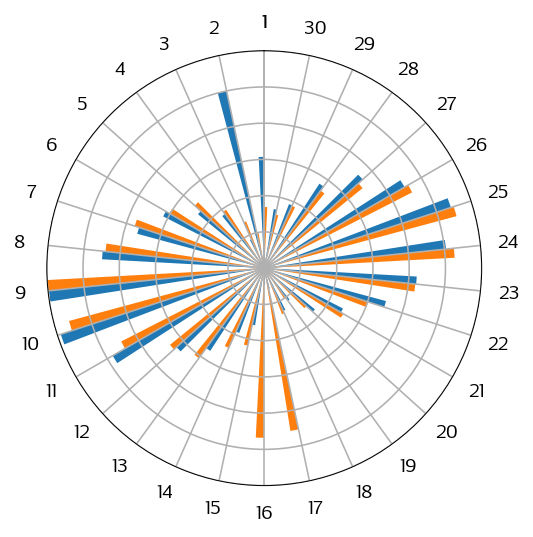

In [152]:
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(polar=True)

_ = ax.set_thetagrids(np.degrees(extra_label_loc), labels=extra_labels)
ax.set_yticklabels([])
ax.set_ylim(0, r_max)
ax.set_theta_zero_location("N")


extra_avgs = stats.lognorm(loc=extra_locs, s=0.2).rvs([2, n_extra_genes], random_state=SEED)
extra_avgs = np.concatenate([
    symmetrize(extra_avgs[:, ::2]),
    symmetrize(extra_avgs[:, 1::2]),
    ], axis=1)

roll_avgs = np.roll(pop_avgs[:,:-1], 1, axis=1)
extra_avgs = np.concatenate([
    roll_avgs[:, :2], extra_avgs[:, :n_extra_genes//2],
    roll_avgs[:, 2:], extra_avgs[:, n_extra_genes//2:]                            
                                ], axis=1)

# extra_avgs = np.concatenate([extra_avgs, extra_avgs[:, [0]]], axis=1)

# extra_idxs = 

width = 0.05
ax.bar(np.array(extra_label_loc)[:-1] - width/2, extra_avgs[0,:], width = width, color=d_color)
ax.bar(np.array(extra_label_loc)[:-1] + width/2, extra_avgs[1,:], width = width, color=h_color)
# ax.bar(np.array(extra_label_loc) - width/2, extra_avgs[0,:], width = width, color='0.3')
# ax.bar(np.array(extra_label_loc) + width/2, extra_avgs[1,:], width = width, color='0.3')